In [2]:
import numpy as np
import os
from lpc.utils import *

from utils import butter_lowpass_filter, plot

Now we want to distinguish voiced and unvoiced sounds. Also, for voiced
sounds we estimate the base tone frequency. We will compare voiced vowel 'a'
and Polish unvoiced 'sz' consonant as we go.

Procedure will be performed for arbitrarily chosen time window of approx.
30ms.

We compare 3 methods:
 * autocorrelation function method
 * AMDF (_Average Magnitude Difference Function_) method
 * cepstral method  

Another method exists, which utilizes inverse filter. That however requires
estimation of vocal tract filter parameters and is done in **vocal_tract_estimation**
notebook.

In [3]:
audio_dir = os.path.join('.', '..', 'audio')
fs = 44100

a_path = os.path.join(audio_dir, 'a.wav')
sz_path = os.path.join(audio_dir, 'sz.wav')
a_audio = get_audio(a_path)
sz_audio = get_audio(sz_path)

a_left = a_audio[:, 0]
sz_left = sz_audio[:, 0]

## Autocorrelation method
We perform two preprocessing steps:
  * first we LP-filter with cutoff 900Hz to remove high frequency hiss 
    influence
  * next we multiply our 30ms signal by a Hamming window 

In [4]:
a_lp = butter_lowpass_filter(a_left, 900, sample_rate=fs)
sz_lp = butter_lowpass_filter(sz_left, 900, sample_rate=fs)

window_len = int(0.03 * fs)
hamming = np.hamming(window_len)

offset = 40000  # large offset due to some artifacts(?) at the beginning of the recording 
a_window = a_lp[offset:offset + window_len]
sz_window = sz_lp[offset: offset + window_len]

a_window *= hamming
sz_window *= hamming

In [5]:
a_corr = np.correlate(a_window, a_window, mode='same')
sz_corr = np.correlate(sz_window, sz_window, mode='same')
a_corr = a_corr[len(a_corr) // 2:]
sz_corr = sz_corr[len(sz_corr) // 2:]

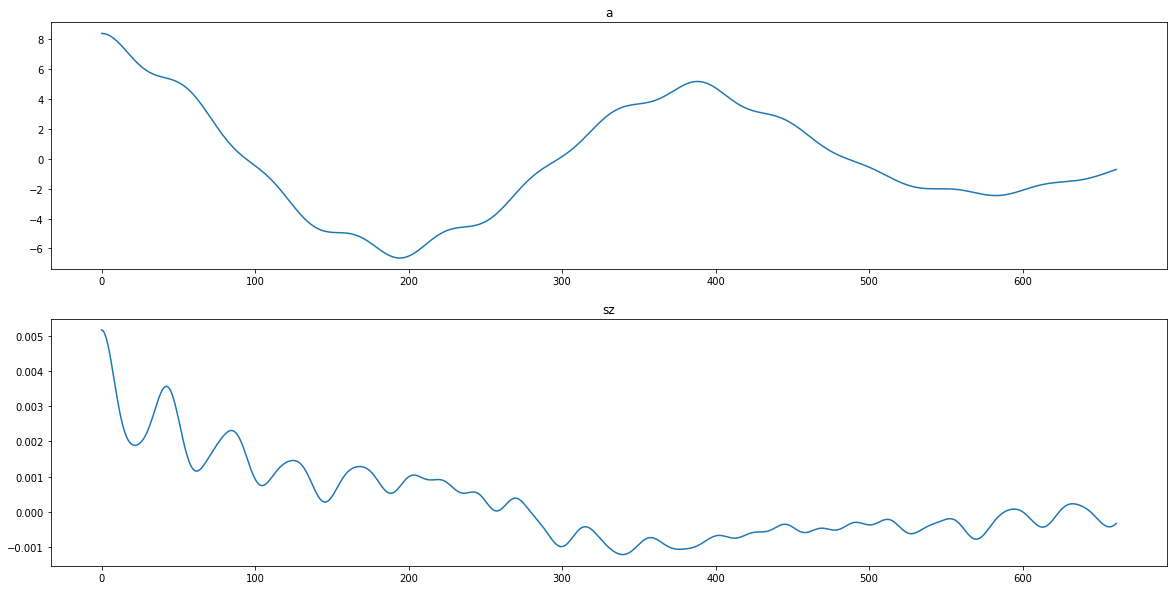

In [6]:
plot([a_corr, sz_corr], ['a', 'sz'])

As we can see, voiced sound has cleanly visible base tone frequency,
whereas unvoiced sound not so much and looks more like non-periodic signal.

Let us now estimate the base tone frequency for 'a' vowel. We do that
by finding time period to the first occurrence of (sufficiently large) 
maximum of autocorrelation function in the interval of legitimate base 
tone time periods (_legitimate_ is quite arbitrary here).

In [43]:
base_tone_min_freq = 100
base_tone_max_freq = 400
bt_max_s = int(fs / base_tone_min_freq)
bt_min_s = int(fs / base_tone_max_freq)

def find_period(corr):
    max_ind = np.argmax(corr[bt_min_s:bt_max_s])
    if corr[bt_min_s + max_ind] > 0.35 * corr[0]:
        return (max_ind + bt_min_s) / fs
    else:
        return 0  # well, works most of the time...
    
a_base_period = find_period(a_corr)
sz_base_period = find_period(sz_corr)
print("'a' base frequency: {:.2f}Hz".format(1 / a_base_period))

'a' base frequency: 113.66Hz


Base tone for 'a' vowel was found to be around 113Hz and we could not find sufficiently strong maximum for 'sz'. Hence it would be automatically categorized as an unvoiced sound.

## AMDF
We use already preprocessed windows of signals, but this time a different function is applied in place of autocorrelation.

In [23]:
def amdf(arr):
    amdf_arr = np.empty(arr.shape[0])
    
    for k in range(arr.shape[0]):
        acc = 0
        for i in range(arr.shape[0] - k):
            acc += np.abs(arr[i] - arr[i + k])
        amdf_arr[k] = acc
        
    return amdf_arr

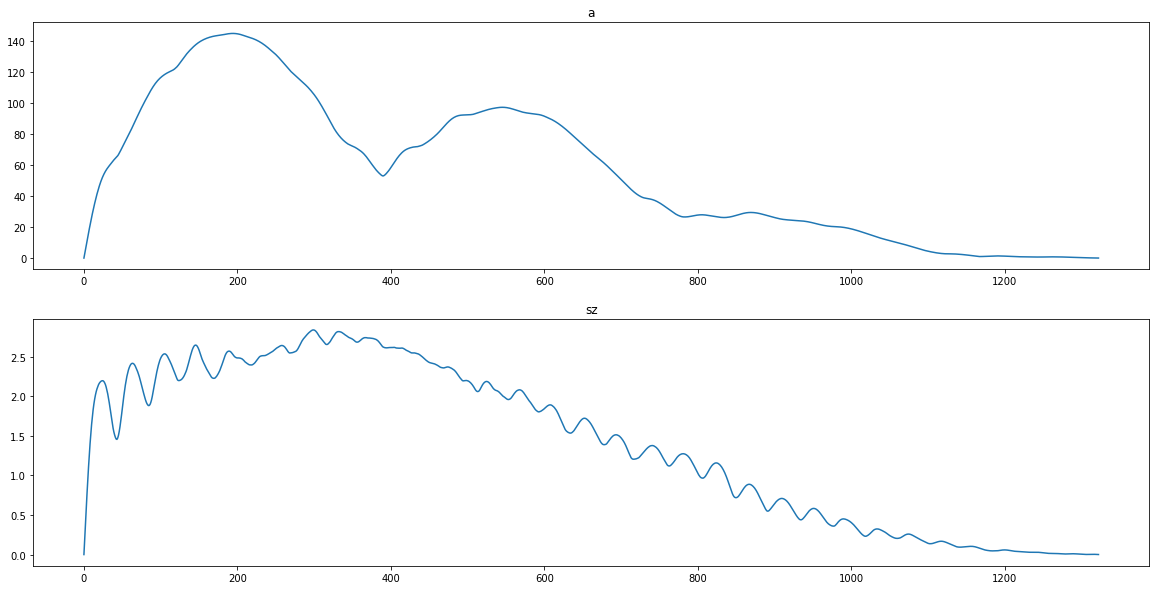

In [26]:
a_amdf = amdf(a_window)
sz_amdf = amdf(sz_window)

plot([a_amdf, sz_amdf], ['a', 'sz'])

As we can see, this function has different properties. This time it's not the maximum in appropriate time period range, but the minimum value that indicates the base tone period. Lack of distinct minimum in 'sz' case suggests that there is no base tone present in the signal. 

Also, we can tell that if we chose too low of a frequency as lower bound for the base tone, we might find the second harmonic (period around 800 sampling periods) instead of the original tone. So the method might require some fine tuning of threshold values before working properly.

In [41]:
def find_period_amdf(arr):
    min_ind = np.argmin(arr[bt_min_s:bt_max_s])
    if arr[bt_min_s + min_ind] > 0.6 * np.max(arr):
        return 0  # well, works most of the time...
    else:
        return (min_ind + bt_min_s) / fs

a_base_period_amdf = find_period_amdf(a_amdf)
sz_base_period_amdf = find_period_amdf(sz_amdf)
print("'a' base frequency (AMDF): {:.2f}Hz".format(1 / a_base_period_amdf))

'a' base frequency (AMDF): 113.08Hz


So it seems we've found 'sz' to be unvoiced again and similar base tone frequency for 'a'.